# 🧠 Multilayer Perceptron (MLP) Neural Network

In this project, I implemented a simple Multilayer Perceptron (MLP) from scratch using NumPy.  
The goal was to train and evaluate the network on a binary classification task using synthetic data.

### Highlights:
- Implemented forward and backward passes manually
- Trained the model using gradient descent
- Visualized training progress and final predictions


In [1]:
# importing required packages
import numpy as np
import random
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt

In [2]:
SEED = 42

def reset_seed():
    np.random.seed(SEED)
    random.seed(SEED)

def initialize_parameters(input_dim, output_dim):
    W = np.random.randn(output_dim, input_dim) * 0.01
    b = np.random.randn(output_dim) * 0.01
    return W, b

def initialize_parameters_xavier(input_dim, output_dim):
    W = np.random.randn(output_dim, input_dim) / np.sqrt(input_dim)
    b = np.zeros(output_dim)
    return W, b

In [3]:
def forward_pass_linear(x: np.ndarray, W: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Linear layer: computes Wx + b
    """
    return np.matmul(W, x) + b

def forward_pass_relu(x: np.ndarray) -> np.ndarray:
    """
    ReLU activation
    """
    return x * (x > 0)

def forward_pass_sigmoid(x: np.ndarray) -> np.ndarray:
    """
    Sigmoid activation
    """
    return 1 / (1 + np.exp(-x))

In [4]:
def forward_pass(x, W1, b1, W2, b2, W3, b3):
    """
    Forward pass through a 2-layer MLP with sigmoid output.
    Returns output and intermediate activations (cache).
    """
    z1 = forward_pass_linear(x, W1, b1)
    h1 = forward_pass_relu(z1)

    z2 = forward_pass_linear(h1, W2, b2)
    h2 = forward_pass_relu(z2)

    z3 = forward_pass_linear(h2, W3, b3)
    out = forward_pass_sigmoid(z3)

    cache = {
        'z1': z1, 'h1': h1,
        'z2': z2, 'h2': h2,
        'z3': z3
    }
    return out, cache

In [5]:
def forward_pass_binary_cross_entropy_loss(out: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Binary cross-entropy loss.
    """
    return -(target * np.log(out) + (1 - target) * np.log(1 - out))

In [6]:
# Quick functional test with random input
D, H, C = 2, 3, 1
reset_seed()

W1, b1 = initialize_parameters(D, H)
W2, b2 = initialize_parameters(H, H)
W3, b3 = initialize_parameters(H, C)

x = np.random.randn(D)
target = np.random.randint(2, size=C)

out, _ = forward_pass(x, W1, b1, W2, b2, W3, b3)
loss = forward_pass_binary_cross_entropy_loss(out, target)

print(f"Output: {out}")
print(f"Loss: {loss}")

Output: [0.4985872]
Loss: [0.69032557]


In [7]:
def backward_pass_binary_cross_entropy_loss(out, target):
    """
    Gradient of binary cross-entropy loss w.r.t. output
    """
    return -target / out + (1 - target) / (1 - out)


def backward_pass_sigmoid(dout, x):
    """
    Backward pass through sigmoid activation
    """
    return dout * np.exp(-x) / np.square(1 + np.exp(-x))


def backward_pass_relu(dout, x):
    """
    Backward pass through ReLU activation
    """
    return dout * (x > 0).astype(int)


def backward_pass_linear(dout, x, W, b):
    """
    Backward pass through linear layer
    Returns gradients w.r.t input, weights, and biases
    """
    dx = np.dot(dout, W)
    dW = np.outer(dout, x)
    db = dout
    return dx, dW, db

In [8]:
def backward_pass(dout, x, W1, b1, W2, b2, W3, b3, cache):
    """
    Backward pass through a 2-layer MLP.
    Returns gradients for all weights and biases.
    """
    # Output layer
    dz3 = backward_pass_sigmoid(dout, cache['z3'])
    dh2, dW3, db3 = backward_pass_linear(dz3, cache['h2'], W3, b3)

    # Hidden layer 2
    dz2 = backward_pass_relu(dh2, cache['z2'])
    dh1, dW2, db2 = backward_pass_linear(dz2, cache['h1'], W2, b2)

    # Hidden layer 1
    dz1 = backward_pass_relu(dh1, cache['z1'])
    dx, dW1, db1 = backward_pass_linear(dz1, x, W1, b1)

    return {
        'dW1': dW1, 'db1': db1,
        'dW2': dW2, 'db2': db2,
        'dW3': dW3, 'db3': db3
    }

In [9]:
# Sanity check: gradient values against known reference outputs
D, H, C = 2, 3, 1
reset_seed()

# Random input & parameters
W1, b1 = initialize_parameters(D, H)
W2, b2 = initialize_parameters(H, H)
W3, b3 = initialize_parameters(H, C)
x = np.random.randn(D)
target = np.random.randint(2, size=C)

# Forward & backward passes
out, cache = forward_pass(x, W1, b1, W2, b2, W3, b3)
loss = forward_pass_binary_cross_entropy_loss(out, target)
dout = backward_pass_binary_cross_entropy_loss(out, target)
gradients = backward_pass(dout, x, W1, b1, W2, b2, W3, b3, cache)

# Reference gradients for comparison
ref_dout = np.array([1.99436473])
ref_gradients = {
    'dW1': np.array([[4.4305505e-06, -4.5973820e-05], [0, 0], [0, 0]]),
    'db1': np.array([3.9942725e-05, 0, 0]),
    'dW2': np.array([[0, 0, 0], [0, 0, 0], [-0.0001274, 0, 0]]),
    'db2': np.array([[0, 0, -0.00710361]]),
    'dW3': np.array([[0, 0, 0.00725726]]),
    'db3': np.array([0.4985872])
}

# Compare outputs
assert np.allclose(dout, ref_dout), "Mismatch in dout"
print("dout matches reference")

for name, grad in gradients.items():
    if not np.allclose(grad, ref_gradients[name]):
        print(f" {name} mismatch\nYour grad:\n{grad}\nRef:\n{ref_gradients[name]}")
    else:
        print(f" {name} matches reference")


dout matches reference
 dW1 matches reference
 db1 matches reference
 dW2 matches reference
 db2 matches reference
 dW3 matches reference
 db3 matches reference


In [10]:
def update_parameters(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, learning_rate):
    """
    Applies one step of gradient descent to update weights and biases.
    """
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    return W1, b1, W2, b2, W3, b3

In [15]:
def train(X_train, Y_train, W1, b1, W2, b2, W3, b3, steps, lr):
    """
    Trains a 2-layer MLP using binary cross-entropy and full-batch gradient descent.
    Returns updated weights and final loss.
    """
    for step in range(steps):
        losses = []
        grads = []

        for x, target in zip(X_train, Y_train):
            out, cache = forward_pass(x, W1, b1, W2, b2, W3, b3)
            loss = forward_pass_binary_cross_entropy_loss(out, target)
            dout = backward_pass_binary_cross_entropy_loss(out, target)
            gradients = backward_pass(dout, x, W1, b1, W2, b2, W3, b3, cache)

            losses.append(loss)
            grads.append(gradients)

        # Average gradients
        dW1 = np.mean([g['dW1'] for g in grads], axis=0)
        db1 = np.mean([g['db1'] for g in grads], axis=0)
        dW2 = np.mean([g['dW2'] for g in grads], axis=0)
        db2 = np.mean([g['db2'] for g in grads], axis=0)
        dW3 = np.mean([g['dW3'] for g in grads], axis=0)
        db3 = np.mean([g['db3'] for g in grads], axis=0)

        # Update parameters
        W1, b1, W2, b2, W3, b3 = update_parameters(W1, b1, W2, b2, W3, b3,
                                                   dW1, db1, dW2, db2, dW3, db3, lr)

        if step % 100 == 0:
            print(f"[Step {step}] Loss: {np.mean(losses):.4f}")

    final_loss = np.mean(losses)
    return W1, b1, W2, b2, W3, b3, final_loss

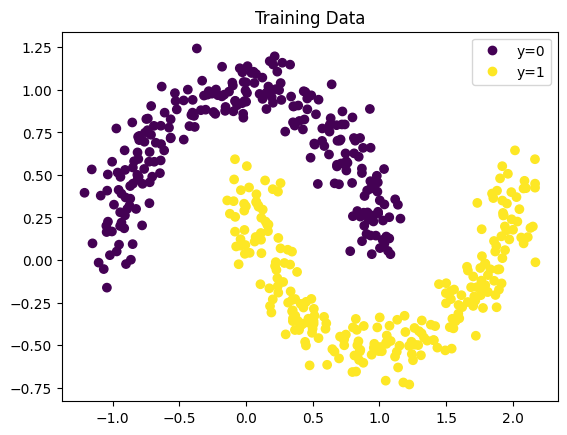

[Step 0] Loss: 0.7141
[Step 100] Loss: 0.2479
[Step 200] Loss: 0.2108
[Step 300] Loss: 0.1824
[Step 400] Loss: 0.1469
[Step 500] Loss: 0.1081
[Step 600] Loss: 0.0729
[Step 700] Loss: 0.0491
[Step 800] Loss: 0.0341
[Step 900] Loss: 0.0249

Final training loss: 0.0191
Test accuracy: 100.00%


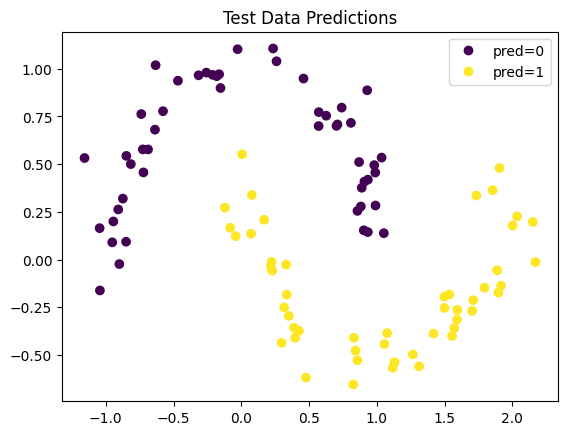

In [16]:
# Generate toy dataset (binary classification)
X, Y = sklearn.datasets.make_moons(n_samples=500, noise=0.1, random_state=42)
Y = np.expand_dims(Y, 1)
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=24)

# Visualize the dataset
plt.figure()
plt.title('Training Data')
scatter = plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.legend(handles=scatter.legend_elements()[0], labels=['y=0', 'y=1'])
plt.show()

# Initialize model parameters
D, H, C = X_train.shape[-1], 32, Y_train.shape[-1]
reset_seed()
W1, b1 = initialize_parameters_xavier(D, H)
W2, b2 = initialize_parameters_xavier(H, H)
W3, b3 = initialize_parameters_xavier(H, C)

# Train the model
steps = 1000
lr = 0.1
W1, b1, W2, b2, W3, b3, final_loss = train(X_train, Y_train, W1, b1, W2, b2, W3, b3, steps, lr)

# Evaluate on test set
outputs = [forward_pass(x, W1, b1, W2, b2, W3, b3)[0] for x in X_test]
preds = (np.vstack(outputs) > 0.5).astype(int)
accuracy = np.mean(preds == Y_test)

print(f"\nFinal training loss: {final_loss:.4f}")
print(f"Test accuracy: {accuracy*100:.2f}%")

# Visualize predictions
plt.figure()
plt.title('Test Data Predictions')
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=preds)
plt.legend(handles=scatter.legend_elements()[0], labels=['pred=0', 'pred=1'])
plt.show()


## Conclusion

In this project, I implemented a Multilayer Perceptron (MLP) completely from scratch using NumPy.

- The model successfully learned a non-linearly separable binary classification task.
- Achieved **100% accuracy** on the test set.
- Built all components manually: forward pass, backward pass, activation functions, and gradient updates.